<a href="https://colab.research.google.com/github/andrerubeis/My-Projects/blob/main/Academic%20Projects/Network%20Dynamics/Labs/Lab08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Continuous Time Markov Chains

In CTMC, the time is not discrete ($t=0,1,\ldots$) but it flows in a continuum ($ t \geq 0$).

The random process still describes the evolution of a state variable $x$ inside a discrete state space $\mathcal X$ with a graph structure.
A graph $G =(\mathcal X, \Lambda)$ with nodes $\mathcal X$ and weight matrix $\Lambda$ describes possible transitions between nodes/states.

Transitions now happen at random time instants that are decided by the tick of a so called "Poisson clock". A Poisson clock is characterized by the property that the time elapsed between any two of
its consecutive ticks is an independent random variable with exponential distribution with a specified rate.

**Remark 1**:
to simulate continuous time Markov chains the following fact will be useful.
To simulate a Poisson clock with rate $r$, one must simulate the time between two consecutive ticks, which we denote $t_{next}$. We can compute $t_{next}$ as

$$ t_{next} = - \frac{\ln(u)}{r}$$

where $u$ is a random variable with uniform distribution, $u \in \mathcal{U}(0,1)$.


### Modelling Continuous time Markov chains
There are two equivalent ways of modelling CTMCs.

**1st approach**
1. you define a unique "global" Poisson clock with an appropriate rate $\omega^* = \max_i(\omega_i)$ where $\omega_i= \sum_j \Lambda_{ij}$
2. when you are at node $i$ and **the global clock ticks**, either you jump to a neighbor $j$ with probability $Q_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j$ or you stay in the same node (no transition) with probability $Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}$

In this approach, the continuous time is "discretized" using a global clock, while the matrix Q describes the jumps. For this reason the matrix Q is called **jump chain** of the CTMC.

**2nd approach**
1. each node $i$ is equipped with its own Poisson clock with rate $\omega_i= \sum_j \Lambda_{ij}$.
2. when you are at node $i$ and **the clock of that node ticks**, you jump to a neighbor $j$ with probability  $P_{ij} = \frac{\Lambda_{ij}}{\omega_i}$

### Example

Suppose that the weather can be modelled as a continuous-time Markov chain, with state space $\mathcal{X} = \{sunny,rainy, cloudy,snowy\}$. Let the transition rates be

![transitionRates](https://github.com/andrerubeis/My-Projects/blob/main/Academic%20Projects/Network%20Dynamics/Labs/transitionMatrix.png?raw=1)

1. The probability distribution $\bar{\pi}(t)$ of the CTMC $X(t)$ with transition rate matrix $\Lambda$ is defined as

$$
\bar{\pi}_i(t) = \mathbb P(X(t) = i), \quad i \in \mathcal X \,.
$$

It evolves according to the equation

$$
\frac{d}{dt} \bar{\pi}(t) = -L'\bar{\pi}(t)
$$

where $L= diag(w) - \Lambda$, with $w = \Lambda \mathbf{1}$.

Thus, invariant probability vector are eigenvector of $L'$ corresponding to eigenvalue $0$. It can also be proven that $\bar{\pi}$ is the left dominant eigenvector of $Q$, where $Q$ is defined as

$$
Q_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j \quad Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}
$$

with $\omega = \Lambda \mathbf{1}$ and $\omega_{*}=\max_i \omega_i$.

Compute the invariant probability vector $\bar{\pi}$ of the CTMC by determining the leading eigenvector of the matrix $Q'$

In [14]:
import numpy as np 

Lambda = [
[0, 1/30, 1/15, 1/60],
[1/60, 0, 1/10, 1/100],
[1/25, 1/10, 0, 1/50],
[1/100, 1/10, 1/10, 0]]
w = np.sum(Lambda, axis=1)
w_star = np.max(w)
Q = Lambda/w_star 
# add the diagonal part
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))

values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)




pi_bar= [0.1847888  0.38682682 0.36092451 0.06745987]


2. Simulate the continuous-time Markov chain starting from sunny weather. Do this following the two different approaches:

**a)** 1st approach, i.e., using global clock with rate $\omega^* = \max_i{\omega_i}$ and the conditional probability matrix $Q$.

**b)** 2nd approach, i.e., using a rate-$\omega_i$ clock in each node $i$ and the conditional probability matrix $P$.

In both cases:
- plot the trajectory for the first 20 jumps,
- use the simulation to estimate $\bar{\pi}$.

Estimate of pi_bar: [0.20137618 0.36966821 0.36080521 0.0681504 ]


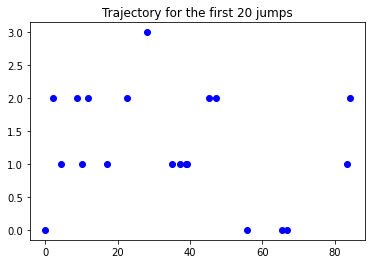

In [15]:
# 1st approach: global clock with rate w_star and matrix Q

# set the number of steps in the simulation
n_steps = 1000
# pos will keep trace of the visited states
pos = np.zeros(n_steps, dtype=int)
# we start from state 0 (sunny)
pos[0] = 0
# transition_times will store the time instants at which
# jumps/transitions happen
transition_times = np.zeros(n_steps)
# the random time to wait for the next transition
# is drawn according to its distribution, discussed in Remark 1
# NOTE: in the formula for t_next we use w_star, the rate of the
# "global" Poisson clock
t_next = -np.log(np.random.rand())/w_star

# Compute the cumulative sums of the rows of Q
# for ex., if a = np.array([[1,2,3],
#                         [4,5,6]])
# np.cumsum(a, axis=1) gives array([[ 1,  3,  6],
#                                   [ 4,  9, 15]])
Q_cum = np.cumsum(Q, axis=1)

for i in range(1,n_steps):
    # the next state to visit will be extracted according to the probabilities
    # stored in the row of Q corresponding to the current state.
    # In general, to extract a value pos[i] in (0,...,num_states-1) according to the discrete
    # distribution Q[pos[i-1],:], you can extract a random number in [0,1] and compare it with 
    # the cumulative sums Q_cum[pos[i-1]]. You then pick the first (smallest) state for which
    # the cumulative sum is grater than the random number.
    pos[i] = np.argwhere(Q_cum[pos[i-1]] > np.random.rand())[0]
    # store the time instant of the current transition
    transition_times[i] = transition_times[i-1] + t_next
    # compute the waiting time to the next transition
    t_next = -np.log(np.random.rand())/w_star

import matplotlib.pyplot as plt

# plot the trajectory for the first 20 jumps
plt.plot(transition_times[0:20], pos[0:20], 'bo')
plt.title('Trajectory for the first 20 jumps')

# Estimate pi

pi_estimate = np.zeros(4)
# We have the time instants of all transitions, we now compute time intervals.
# np.diff computes the n-th discrete difference of a vector.
# Here we set n=1 to compute first difference, which is given by 
# intervals[i] = transition_times[i+1] - transition_times[i].
# We also provide a value to  append to transition_times prior to performing the difference
# so that we can compute also the last interval: 
# transition_times[-1] + t_next is the end of the time horizon.
intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)

# for each state in the state space
for state in range(4):
    # identify the steps when we visited that state during the process
    visits = np.argwhere(pos == state)
    # the estimate of the invariant measure for that state is equal to the
    # time spent on the state divided the total time of the process
    pi_estimate[state] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
    
print("Estimate of pi_bar:", pi_estimate)

Estimate of pi_bar: [0.2009867  0.37372516 0.3657336  0.05955455]


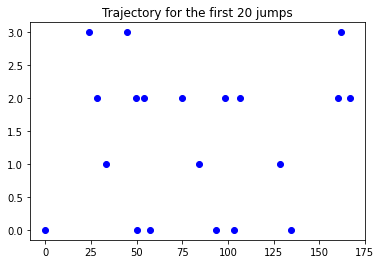

In [16]:
# 2nd approach: local clocks with rates w_i and matrix P

# contruct the P matrix (instead of Q) and clock rates w
w = np.sum(Lambda, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

# set the number of steps in the simulation
n_steps = 1000
# pos will keep trace of the visited states
pos = np.zeros(n_steps, dtype=int)
# we start from state 0
pos[0] = 0
# transition_times will store the time instants at which
# jumps/transitions happen
transition_times = np.zeros(n_steps)
# the random time to wait for the next transition
# is drawn according to its distribution, discussed in Remark 2
# NOTE: in the formula for t_next we use the rate of the clock of 
# the current state, in this case w[0].
t_next = -np.log(np.random.rand())/w[0]

# Compute the cumulative sums of the rows of P
P_cum = np.cumsum(P, axis=1)

for i in range(1,n_steps):
    # the next state to visit will be extracted according to the probabilities
    # stored in the row of P corresponding to the current state.
    pos[i] = np.argwhere(P_cum[pos[i-1]] > np.random.rand())[0]
    # store the time instant of the current transition
    transition_times[i] = transition_times[i-1] + t_next
    # compute the waiting time to the next transition
    # NOTE: we use the rate w[pos[i]] of the clock of the current position
    t_next = -np.log(np.random.rand())/w[pos[i]]

import matplotlib.pyplot as plt

# plot the trajectory for the first 20 jumps
plt.plot(transition_times[0:20], pos[0:20], 'bo')
plt.title('Trajectory for the first 20 jumps')

# Estimate pi

pi_estimate = np.zeros(4)

intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)
for node in range(4):
    visits = np.argwhere(pos == node)
    pi_estimate[node] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
print("Estimate of pi_bar:", pi_estimate)

3. An ice-cream shop’s profit depends on the weather. Their profit per time unit is given by the following function

$$
f(X) = \begin{cases} 
10 & \text{if X = sunny}\\
2 & \text{if X = cloudy}\\
1 & \text{if X = rainy}\\
0 & \text{if X = snowy}
\end{cases}
$$

Simulate how the profit grows with time. Compute the average profit, both from the simulation and from the stationary distribution $\bar{\pi}$.

In [17]:
# Simulation of profit growth
# I choose to simulate the CTMC following the first approach

# set the number of steps in the simulation
n_steps = 1000
# payoff values corresponding to each state
payoff = [10, 2, 1, 0]

pos = np.zeros(n_steps, dtype=int)
pos[0] = 0
transition_times = np.zeros(n_steps)
# since I'm following the first simulation approach, here I divide by the rate
# w_star of the global clock
t_next = -np.log(np.random.rand())/w_star
# we define a profit variable, which stores the comulative profit up to
# the current time. For the first interval, which is t_next long, 
# the profit grows by payoff[pos[0]]*t_next
profit = payoff[pos[0]]*t_next

Q_cum = np.cumsum(Q, axis=1)

# we evolve the process as done before, increasing at each step the total profit
for i in range(1,n_steps):
    pos[i] = np.argwhere(Q_cum[pos[i-1]] > np.random.rand())[0]
    transition_times[i] = transition_times[i-1] + t_next
    # compute the waiting time to the next transition
    # NOTE: we use the rate w[pos[i]] of the clock of the current position
    t_next = -np.log(np.random.rand())/w_star
    # during the next interval, which is t_next long, the process will be in state
    # pos[i] and the profit will grow by payoff[pos[i]]*t_next
    profit = profit + payoff[pos[i]]*t_next
    
# the average profit is estimated as the overall profit obtained along the
# simulation divided by the total time of the process
average_profit = profit/(transition_times[-1] + t_next)
print("Average profit", average_profit)

Average profit 3.143820419153886


Compare with the average payoff of the invariant distribution, computed as 

$$
\bar{f} = \sum_{X \in \mathcal X} f(X)\bar{\pi}_X
$$

The two estimates should be equivalent as $t$ grows large because of ergodic theorem.

In [18]:
# TO DO

# Epidemic Models on Networks
In this section we consider a special kind of continuous time Markov chain, which is used to simulate the spread of epidemics (as well as other pairwise interacting network systems) over a network.

### Theory recap: Pairwise interacting network systems

Consider a finite population of agents, identified with the nodes of a graph $\mathcal G = (\mathcal V, \mathcal E, W)$. 
Each agent $i \in \mathcal V$ has a state $x_i \in \mathcal A$ and all states are collected in the configuration vector $x \in \mathcal X = \mathcal A^{\mathcal V}$.

We consider an **evolution process** for the state vector $X(t)$ which is _caused by pairwise interactions between neighbouring nodes in the graph and by spontaneous mutation_.
- Each node is equipped with a Poisson clock with rate $1$. When the clock ticks, the agent is activated and it undergoes a **spontaneous mutation**.The probabilities of spontaneous mutations (conditional on the ticking of the clock) are described by the **mutation kernels**

$$
\psi^{(i)}\in\mathbb{R}^{\mathcal A\times\mathcal A}\,,\qquad  i\in\mathcal V	
$$

- Each directed link has a Poisson clock with rate $\beta W_{ij}$. When the clock ticks, the link is activated, agent $i$ meets agent $j$ and as a consequence $i$ makes a **transition**.  The transition probabilities (conditional on the ticking of the clock) are described by the **pairwise interaction kernels**

$$
\varphi^{(i,j)}(c)\in\mathbb{R}^{\mathcal A\times\mathcal A}\,,\qquad (i,j)\in\mathcal E\,,\qquad c\in\mathcal A
$$
    
Then, pairwise interacting network systems are **continuous time Markov chains** with state space $\mathcal X = \mathcal A^{\mathcal V}$ and transition rates

$$
\Lambda_{x,y}=\begin{cases}
\psi^{(i)}_{x_i,y_i}+\beta\sum_jW_{ij}\varphi_{x_iy_i}^{(i,j)}(x_j) \quad \text{  if  } x_i\ne y_i\text{ and }x_{-i}=y_{-i}\\
0 \quad \text{  if  } x\text{ and }y\text{ differ in more than }1\text{ element}\,,
\end{cases}$$

The main models you studied during the lectures are:

$$\textbf{SI:}\qquad\psi=\left[\begin{array}{cc}1&0\\0&1\end{array}\right]\qquad\varphi(S)=\left[\begin{array}{cc}1&0\\0&1\end{array}\right]\qquad\varphi(I)=\left[\begin{array}{cc}0&1\\0&1\end{array}\right] $$


$$\textbf{SIS:}\qquad\psi=\left[\begin{array}{cc}1&0\\1&0\end{array}\right]\qquad\varphi(S)=\left[\begin{array}{cc}1&0\\0&1\end{array}\right]\qquad\varphi(I)=\left[\begin{array}{cc}0&1\\0&1\end{array}\right] $$


$$\textbf{SIR:}\qquad\psi=\left[\begin{array}{ccc}1&0&0\\0&0&1\\0&0&1\end{array}\right]\qquad\varphi(S)=\varphi(R)=\left[\begin{array}{ccc}1&0&0\\0&1&0\\0&0&1\end{array}\right]\qquad\varphi(I)=\left[\begin{array}{ccc}0&1&0\\0&1&0\\0&0&1\end{array}\right]$$

## SI model
The SI model is a pairwise interacting network system characterized by the following interaction kernels:

$$
\phi(0) = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}, \quad
\phi(1) = \begin{pmatrix} 0 & 1 \\ 0 & 1 \end{pmatrix}
$$

In the SI model, each node can be either in a susceptible (denoted S or 0) or infected (denoted I or 1) state. When a susceptible node makes contact with an infected one, the contagion spreads and the susceptible node becomes infected.

### Example: SI model on a grid
In this example we consider the SI model on a $3 \times 3$ grid. We simulate the evolution of the epidemics starting from a configuration where only one node is infected and all the rest are susceptible.

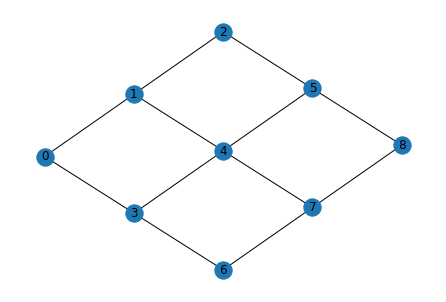

In [19]:
# Construct the graph describing interactions among agents

import networkx as nx

size = 3
# Create Grid Graph
G = nx.grid_2d_graph(size,size)

# Make node relabelling
f = dict()
for v in G.nodes:
    f[v] = v[0]*size+v[1]

G = nx.relabel_nodes(G, f)
nx.draw_spectral(G, with_labels=True)

In [24]:
# Define the Markov chain by constructing its transition matrix Lambda
import scipy as sp
# Number of agents
n_agents = len(G)

# Pairwise interaction kernels
# 3-dimensional array
phi = np.array([[[1,0],
                 [0,1]], 
                [[0,1],
                 [0,1]]])

# Links activation rate 
beta = 1


# Adjacency matrix
W = nx.convert_matrix.to_numpy_matrix(G)

# Initialize transition rates matrix
n_config = 2**n_agents

Lambda = sp.sparse.lil_matrix((n_config,n_config))

# Number of states for each agent
n_states = tuple(2 for _ in range(len(G)))

# Fill transition rates matrix
# For each configuration x, we consider all configurations y that differ only
# in the state of a single agent and we compute the rate for the admissble 
# transition x->y
for x_id in range(n_config):
    # we create states in the form (0,1,1,0,0,1,...)
    x = np.unravel_index(x_id,shape=n_states)
    x = np.array(x)
    for agent in range(n_agents):
        # construct the state where only the state of an agent is modified
        y = np.array(x)
        y[agent] = 1-y[agent]
        y_id = np.ravel_multi_index(tuple(y), dims = n_states)
        for other_agent in range(n_agents):
            Lambda[x_id, y_id] += beta*W[agent,other_agent]*phi[x[other_agent], x[agent], y[agent]]


AttributeError: ignored

In [ ]:
# Simulate the evolution of the epidemics

# Simulate the Markov chain with local clocks method
w = np.sum(Lambda, axis=1)
# reshape w in vector form
w = np.array(w.T)[0]

for x, weight in enumerate(w):
    if weight == 0:
        # add selfloop if w[x]=0, otherwise P is not well-defined
        Lambda[x,x] = 1
        w[x] = 1

D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

n_steps = 12

# store the ids of visited configurations, describing the state of each agent
states = np.zeros(n_steps, dtype=int)
# in the initial configuration, agent 0 is infected
x0 = np.zeros(n_agents, dtype=int)
x0[0]=1
# define initial state (time 0)
states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)

transition_times = np.zeros(n_steps)
t_next = -np.log(np.random.rand())/w[0]

P_cum = np.cumsum(P, axis=1)

for i in range(1,n_steps):
    states[i] = np.argwhere(P_cum[states[i-1]] > np.random.rand())[0]
    transition_times[i] = transition_times[i-1] + t_next
    t_next = -np.log(np.random.rand())/w[states[i]]

In [ ]:
# Plot the infection spread

import matplotlib.pyplot as plt

pos = nx.spectral_layout(G)
fig = plt.figure(figsize=(15,10))
for t in range(0,n_steps):
    plt.subplot(3,4,t+1)
    x_id = states[t]
    x = np.array(np.unravel_index(x_id, shape = n_states))
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')
    plt.title('jump step = {0}'.format(t+1))

**Remark**: we simulated the evolution of the epidemics by exploiting the general simulation method for continuous time Markov chains viewd in Lab04. This is totally correct, and it is the easiest way to understand and learn the process, but it requires **precomputing the transition matrix** Lambda, which is then used to perform the simulation. Computing the whole Lambda has a large computational cost, and it becomes practically unfeasable when the number of agents grows. To have a better idea, try to repeat the previous simulation on a $4 \times 4$ or $5 \times 5$ grid, and see how the computational time blows up. Indeed, the number of states is $2^{n}$, i.e., it grows exponentially in $n$.

To overcome this issue, a more efficient simulation method is proposed below, which may turn usefull if you need to deal with larger networks or more complicated models (e.g., SIR dynamics, in which the number of states is $3^{n}$). Instead of precomputing the transition matrix Lambda, it computes its rows along the way when needed. In particular, when the process is at some configuration $x$, row $x$ of $\Lambda$ is computed, used to compute the probabilities of transitions from $x$ and to pick the next visited configuration.

Try again to simulate the SI model on a $4 \times 4$ grid with this method to appreciate the computational saving.

In [ ]:
# Simulation with local clocks method
# In this variant, the matrix Lambda is not precomputed
# We just compute the jump chain without taking into account the transition times, but this can be generalized as done before

# for each step of the simulation
for i in range(1,n_steps):
    # consider the current configuration
    x = np.unravel_index(states[i-1],shape=n_states)
    x = np.array(x)
    # define a list of admissible destination configurations, 
    # and the rates of the corresponding transitions
    destinations = list()
    transition_rates = list()
    # admissible destinations differ from the current configuration
    # for the state of a single agent
    for agent in range(n_agents):
        # construct an admissble destination and append it to the list
        y = np.array(x)
        y[agent] = 1-y[agent]
        y_id = np.ravel_multi_index(tuple(y), dims = n_states)
        destinations.append(y_id)
        # compute the transition rate from x to y
        rate = 0
        for other_agent in range(n_agents):
            # for every other_agent in the network, compute its contribution to the rate of the transition of the agent
            rate += beta*W[agent,other_agent]*phi[x[other_agent], x[agent], y[agent]]
        transition_rates.append(rate)
    # given all transition rates from x to admissible y
    # compute w_x, the clock rate of configuration x
    # Notice: transition_rates is the x-th row of Lambda
    transition_rates = np.array(transition_rates)
    w_x = np.sum(transition_rates)
    # if w_x = 0, then the process stays in x
    if w_x == 0:
        states[i] = states[i-1]
    # else, transition probabilities are computed as transition_rates/w_x
    # and the next config is chosen accordingly.
    # Notice: this is the x-th row of P
    else:
        probabilities = transition_rates / w_x
        states[i] = np.random.choice(destinations, p=probabilities)
        
# Plot the infection spread
pos = nx.spectral_layout(G)
fig = plt.figure(figsize=(15,10))
for t in range(0,n_steps):
    plt.subplot(3,4,t+1)
    x_id = states[t]
    x = np.array(np.unravel_index(x_id, shape = n_states))
    nx.draw_spectral(G,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
    nx.draw_spectral(G,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')
    plt.title('jump step = {0}'.format(t+1))

## Theoretical questions on epidemic
- what is the hitting time to the absorbing state;
- when multiple absorbing states exist, what are the absorbing probabilities?

**SI**: only one absorbing state where all the nodes are infected, i.e., $\mathbf{1}$.

**SIS**: only one absorbing state, where all the nodes are susceptible, i.e., $0 \mathbf{1}$.

**SIR**: all the states with no infected are absorbing, i.e., there are $n+1$ absorbing states, where $n$ is the order of the graph .

### Exercise 1: extinction time in SIS dynamics on complete graph.

We are given a complete graph with $n$ nodes. On this graph, the Markov process can be represented by a birth-and-death chain. To see this, let us define for a general undirected graph

$$
N(x) = \mathbf{1}'x = \sum_{i\in \mathcal{V}} x_i \quad \text{and} \quad B(x) = \sum_{i,j \in \mathcal{V}} W_{ij}(1-x_i)x_j.
$$

- $N(x)$ is the number of infected nodes in the configuration $x$.
- $B(x)$ is the active boundary, i.e., the number of links between susceptible and infected agents.

We can describe the evolution of $N(t)\equiv N(X(t))$ as a function of $N(t)$ and $B(t)\equiv B(X(t))$. $N(t)$ may either increase or decrease, i.e., if there is a transition at time $t$, then $N(t^+)=N(t^-)+1$ or $N(t^+)=N(t^-)-1$. This kind of arguments are useful for every binary dynamics, i.e., dynamics with two states. For a given state $x$ and a general pairwise dynamics, the rate at which $N(x)$ increases to $N(x)+1$ is

\begin{align*}
	\sum_{i:x_i=0} \Lambda_{x,x+\delta^{(i)}} &= \sum_{i:x_i=0} \left( \psi_{01} + \beta \sum_{j} W_{ij} \varphi_{01}(x_j)\right) \\
	&= \sum_{i:x_i=0} \psi_{01} + \sum_{i:x_i=0} \beta \sum_{j:x_j=1} W_{ij} \varphi_{01}(1) \\
	&= \underbrace{(n-N(x))}_{\substack{\text{n of nodes} \\ \text{in state 0}}} \psi_{01} + \underbrace{B(x)}_{\substack{\text{n. of links $(i,j)$} \\ \text{s.t. $x_i=0$, $x_j=1$}}} \beta \varphi_{01}(1).
\end{align*}

In the second equality we have used the assumption that $\varphi_{01}(0) = 0$, i.e., more in general if an agent $i$ in state $a$ meets another agent in the state $a$, the agent $i$ does not modify her state.

The rate at which $N(x)$ decreases to $N(x)-1$ is given by

\begin{align*}
	\sum_{i:x_i=1} \Lambda_{x,x-\delta^{(i)}} &= \sum_{i:x_i=1} \left( \psi_{10} + \beta \sum_{j} W_{ij} \varphi_{10}(x_j)\right) \\
	&= \sum_{i:x_i=1} \psi_{10} + \sum_{i:x_i=1} \beta \sum_{j:x_j=0} W_{ij} \varphi_{10}(0) \\
	&= \underbrace{N(x)}_{\substack{\text{n of nodes} \\ \text{in state 1}}} \psi_{10} + \underbrace{B(x)}_{\substack{\text{n of links $(i,j)$} \\ \text{s.t. $x_i=1$, $x_j=0$}}} \beta \varphi_{10}(0).
\end{align*}

For the complete graph, the boundary is function of $N$, in particular $B(x)=N(x) \cdot (n-N(x))$. Thus, the evolution of $N(x)$ depends only on $N$ and $B$, which means that we can describe the evolution of the process by looking only at $N(t)$ instead of the state of the single nodes.

For the SIS dynamics, $\psi_{01}=0, \psi_{10}=1, \phi_{10}(0)=0, \phi_{01}(1)=1$,

thus, the upward transition rate is $\beta N(t) (n-N(t))$, and the downward transition rate is $N(t)$.

**Remark**: this is not a general fact, and depends on the particular choice of the graph.

We thus have a continuous-time birth-and-death process for $N(t)$.

Let $\tau_i$ indicate the expected time such that there are no infected nodes, assuming that $N(0)=i$.

By using the theory of birth-and-death processes, we obtain that

$$
\begin{cases}
\tau_0 = 0 \\
\tau_k = \frac{1}{k+\beta k (n-k)} + \frac{k \tau_{k+1}}{k+\beta k (n-k)} + \frac{\beta k (n-k)}{k + \beta k (n-k)}, \quad 0<k<n \\
\tau_n = \frac{1}{n} + \frac{\tau_{n-1}}{n}.
\end{cases}
$$

Let $\alpha = \beta n$. By some computations (see the lecture nodes for details) one can observe that

- if $\alpha < 1$, then

$$
\tau_n \sim \frac{\log n}{1-\alpha}.
$$

- If $\alpha>1$, then for every $\gamma \in [1/\alpha, 1]$

$$
\tau_1 \ge \frac{(\alpha \gamma)^{(1-\gamma)n}}{\gamma \alpha n}.
$$

Notice that $\alpha$ indicates the expected number of infected that an infected produces in a fully susceptible agents network. There is a phase transition:

- if $\alpha<1$, the extinction time from the fully infected state scales with $\log n$;
- if $\alpha>1$, the extinction time, even from a single infected, grows exponentially in $n$.

Observe that if $\alpha<1$ the expected fraction of infected decreases in time, whereas if $\alpha>1$ the expected fraction of infected increases.

Thus, if $\alpha>1$, the epidemic can be eradicated only due to stochastic fluctuations.

**Exercise**: implement the SIS dynamics in a complete graph, and verify the phase transition for the eradication time in a large complete graph.

In [ ]:
# TO DO

## Exercise 2: absorbing probabilities in SIR dynamics on a ring

In SIR dynamics there are multiple absorbing states (every disease-free state is absorbing). Eventually, the Markov process will reach a disease-free state with probability 1. Instead of computing the absorbing time for a disease-free state, we here ask for every $k \le n$ what is the probability that the Markov process is absorbed in a state with $n-k$ susceptible agents and $k$ recovered agents. This indicates how large the outbreak was.

Let us work with a ring graph, and assume that only one node is infected at the initial time.

We identify the states of the process by two scalar indicators, $I$, $B$, where $I$ now denotes the total number of agents that have been infected from the beginning of the process, and $B$ is number of links between susceptibles and infected agents. Every state is identified through a pair $(I,B)$. 

Since we are not asking the hitting times, but only the absorbing probabilities we can work with the corresponding jump process where the time $n \in \{0,1,2,...\}$ is discrete.

Note that because of the topology of the graph, there are only two types of transitions:

$$
\begin{cases}
I(n+1) = I(n) + 1 \\
B(n+1) = B(n)
\end{cases}
\quad \quad \quad
\begin{cases}
I(n+1) = I(n) \\
B(n+1) = B(n)-1
\end{cases}
$$

The Markov process in the space $(I,B)$ is

![figure](https://github.com/andrerubeis/My-Projects/blob/main/Academic%20Projects/Network%20Dynamics/Labs/continuous_ring-1.png?raw=1)

where the red nodes are absorbing states.

Since we are interested only in the absorbing probabilities, we can construct the associated jumping chain.

![figure](https://github.com/andrerubeis/My-Projects/blob/main/Academic%20Projects/Network%20Dynamics/Labs/discrete_ring-1.png?raw=1)

Let $p_i$ denote the probability that the outbreak size is $i$. It is straighforward to notice that

$$
p_1 = \frac{1}{2\beta+1}.
$$

For $n>i>1$, it is necessary that the first node infects a second node (probability $2\beta/(2\beta+1)$). For a given $i$, there are multiple paths (specifically, $i-1$ paths) from configuration $(2,2)$ to $(i,0)$, each of them with probability

$$
\left(\frac{\beta}{\beta+1}\right)^{i-2} \left(\frac{1}{\beta+1}\right)^2.
$$

Thus, 

$$
p_i = \frac{2\beta}{2\beta+1} \cdot (i-1) \cdot \left(\frac{\beta}{\beta+1}\right)^{i-2} \left(\frac{1}{\beta+1}\right)^2.
$$

For $p_n$ there are $n-2$ paths with probability $\left(\frac{\beta}{\beta+1}\right)^{n-2} \left(\frac{1}{\beta+1}\right)$ and $1$ path with probability $\left(\frac{\beta}{\beta+1}\right)^{n-2}$.

Putting all together,

$$
\begin{cases}
p_1 = \frac{1}{2\beta+1} \\
p_i = \frac{2\beta}{2\beta+1} \cdot (i-1) \cdot \left(\frac{\beta}{\beta+1}\right)^{i-2} \left(\frac{1}{\beta+1}\right)^2 \quad 1<i<n \\
p_n = \frac{2\beta}{2\beta+1} \cdot \left((n-2) \left(\frac{\beta}{\beta+1}\right)^{n-2} \left(\frac{1}{\beta+1}\right) + \left(\frac{\beta}{\beta+1}\right)^{n-2} \right)
\end{cases}
$$

**Limits**:
- $\beta \to 0^+$: $p_1 \to 1$;
- $\beta \to +\infty$: $p_n \to 1$.